In [22]:
# Load core libraries for data wrangling, plotting, and basic modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

Collect and preprocessing the data

In [23]:
# Read the GEFCOM dataset with hourly market info and named columns
gefcom = pd.read_csv(
    'Data/GEFCOM.txt',
    sep=r"\s+",
    names=['Date', 'Hour', 'Price', 'System_load', 'Zonal_load', 'Day_of_week'],
)

In [49]:
# Inspect column data types to confirm how pandas parsed the raw file
gefcom.dtypes


Date               datetime64[ns]
Hour                      float64
Price                     float64
System_load               float64
Zonal_load                float64
Day_of_week               float64
Log_price                 float64
p_lag1                    float64
p_lag2                    float64
p_lag7                    float64
min_price                 float64
Log_system_load           float64
D_1                         int64
D_6                         int64
D_7                         int64
day_id                      int64
dtype: object

In [25]:
# Convert Date from YYYYMMDD integers to pandas datetime objects
gefcom['Date'] = pd.to_datetime(gefcom['Date'], format='%Y%m%d')

In [26]:
# Quick numeric summary to spot the basic scale and outliers
gefcom.describe()

,Date,Hour,Price,System_load,Zonal_load,Day_of_week
count,25968,25968.00000,25968.000000,25968.000000,25968.000000,25968.000000
mean,2012-06-24 12:00:00,11.50000,48.190072,18165.881200,6105.779767,4.000000
min,2011-01-01 00:00:00,0.00000,12.520000,11544.000000,3395.000000,1.000000
25%,2011-09-28 00:00:00,5.75000,33.470000,15620.000000,5131.000000,2.000000
50%,2012-06-24 12:00:00,11.50000,42.870000,18069.000000,6076.000000,4.000000
75%,2013-03-22 00:00:00,17.25000,54.300000,19858.250000,6714.000000,6.000000
max,2013-12-17 00:00:00,23.00000,363.800000,33449.000000,11441.000000,7.000000
std,NaN,6.92232,26.179381,3453.664269,1309.476852,2.002348


In [27]:
# Check how many missing values each column has
gefcom.isna().sum()

Date           0
Hour           0
Price          0
System_load    0
Zonal_load     0
Day_of_week    0
dtype: int64

In [28]:
# Verify whether any duplicate rows are present
gefcom.duplicated().sum()

np.int64(0)

In [29]:
# List the unique hours to ensure we truly have 24 hourly slots
gefcom['Hour'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [30]:
# Count any records with non-positive prices (should stay at zero)
(gefcom['Price'] <= 0).sum()

np.int64(0)

In [ ]:
# Create a log-price column for more stable modeling and keep a copy for plotting
gefcom['Log_price'] = np.log(gefcom['Price'])

,Date,Hour,Price,System_load,Zonal_load,Day_of_week,Log_price
0,2011-01-01,0.0,43.17,15187.0,5091.0,6.0,3.765146
1,2011-01-01,1.0,36.24,14464.0,4918.0,6.0,3.590163
2,2011-01-01,2.0,34.64,13940.0,4763.0,6.0,3.545009
3,2011-01-01,3.0,33.76,13609.0,4660.0,6.0,3.519277
4,2011-01-01,4.0,33.08,13391.0,4599.0,6.0,3.498929
...,...,...,...,...,...,...,...
25963,2013-12-17,19.0,113.92,23091.0,7167.0,2.0,4.735496
25964,2013-12-17,20.0,107.26,22504.0,6958.0,2.0,4.675256
25965,2013-12-17,21.0,89.02,21538.0,6707.0,2.0,4.488861
25966,2013-12-17,22.0,85.40,20025.0,6316.0,2.0,4.447346


# Model building

- ARX: 
$$p_{d,h} = \beta_{0} + \beta_{1p_{d-1,h}} + \beta_{2p_{d-2,h}} + \beta_{3p_{d-7,h}} + \beta_{4p_{min,d-1}} + \beta_{5z_{d}} + \sum \beta_{D} D_{d} + \epsilon_{d,h}$$

In [ ]:
# Build time-based features (price lags, day index, previous-day min) and weekday dummies
# Lags of log price
gefcom["p_lag1"] = gefcom["Log_price"].shift(24)    # p_{d-1,h}
gefcom["p_lag2"] = gefcom["Log_price"].shift(48)    # p_{d-2,h}
gefcom["p_lag7"] = gefcom["Log_price"].shift(168)   # p_{d-7,h}

# Daily minimum log price (previous day)
daily_min = gefcom.groupby("Date")["Log_price"].min().shift(1)
gefcom = gefcom.merge(daily_min.rename("min_price"), on="Date")

# Log system load
gefcom["Log_system_load"] = np.log(gefcom["System_load"])

# Day-of-week dummies (as in the paper: 1, 6, 7)
gefcom["D_1"] = (gefcom["Day_of_week"] == 1).astype(int)
gefcom["D_6"] = (gefcom["Day_of_week"] == 6).astype(int)
gefcom["D_7"] = (gefcom["Day_of_week"] == 7).astype(int)

# Model features
X_cols = ['p_lag1', 'p_lag2', 'p_lag7', 'min_price',
          'Log_system_load', 'D_1', 'D_6', 'D_7']

# Drop rows that have NaNs in predictors OR in Log_price
mask_valid = ~gefcom[['Log_price'] + X_cols].isna().any(axis=1)
gefcom = gefcom[mask_valid].reset_index(drop=True)

# Define day_id AFTER cleaning, so every day has full lags
orig_start_date = gefcom["Date"].min()
gefcom["day_id"] = (gefcom["Date"] - orig_start_date).dt.days

# Keep a copy for plotting
gefcom_plot = gefcom.copy()

/var/folders/kf/fpf7cl4d74g_zpz2l3v784zr0000gn/T/ipykernel_13558/3297423915.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


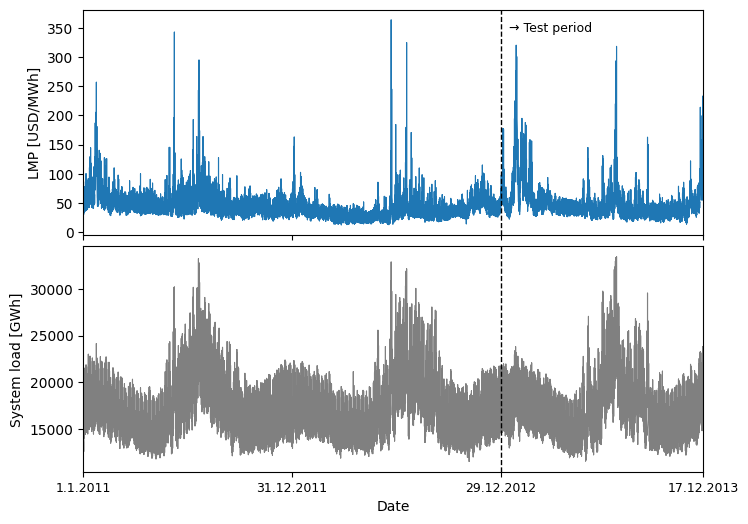

In [ ]:
# Plot prices and system load over time and mark the train/test boundary
x_ticks = [
    pd.Timestamp('2011-01-01'),
    pd.Timestamp('2011-12-31'),
    pd.Timestamp('2012-12-29'),
    pd.Timestamp('2013-12-17')
]

x_labels = ['1.1.2011', '31.12.2011', '29.12.2012', '17.12.2013']

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0.05})

# --- Top panel: Prices
ax1.plot(gefcom_plot['Date'], gefcom_plot['Price'], color='tab:blue', linewidth=0.8)
ax1.set_ylabel('LMP [USD/MWh]', fontsize=10)

# --- Bottom panel: System Load
ax2.plot(gefcom_plot['Date'], gefcom_plot['System_load'], color='gray', linewidth=0.8)
ax2.set_ylabel('System load [GWh]', fontsize=10)
ax2.set_xlabel('Date', fontsize=10)

# --- Set x-axis limits to data range (no empty space)
xmin = gefcom_plot['Date'].min()
xmax = gefcom_plot['Date'].max()
ax1.set_xlim(xmin, xmax)

# --- Set x-axis ticks and labels
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels, fontsize=9)

# --- Add one continuous dashed vertical line for the test period
for ax in [ax1, ax2]:
    ax.axvline(split_date, color='k', linestyle='--', linewidth=1)

# Add annotation
ax1.text(split_date + pd.Timedelta(days=15), 350, '→ Test period', fontsize=9, va='center')

plt.tight_layout()
plt.show()


In [35]:
# Prepare train/test splits, feature matrices, and helpers for rolling-window ARX models
train = gefcom[gefcom['Date'] < split_date].reset_index(drop=True)
test = gefcom[gefcom['Date'] >= split_date].reset_index(drop=True)

windows_length = list(range(28, 729))
hours = range(24)
X_cols = ['p_lag1', 'p_lag2', 'p_lag7', 'min_price', 'Log_system_load', 'D_1', 'D_6', 'D_7']

# Numerical day index (days since start) keeps track of timing for window selection
gefcom['day_id'] = (gefcom['Date'] - orig_start_date).dt.days
test['day_id'] = (test['Date'] - orig_start_date).dt.days

# Convert data to NumPy for faster slicing inside the rolling-window loop
hours_all = gefcom['Hour'].values
day_ids_all = gefcom['day_id'].values
X_all = gefcom[X_cols].to_numpy(dtype=float)
y_all = gefcom['Log_price'].to_numpy(dtype=float)

hours_test_all = test['Hour'].values
test_day_ids_all = test['day_id'].values
test_X_all = test[X_cols].to_numpy(dtype=float)

# Pre-split per-hour data to avoid repeated boolean masks in each window iteration
hour_data = {}
for h in hours:
    mask_train_h = hours_all == h
    mask_test_h = hours_test_all == h
    hour_data[h] = {
        'X': X_all[mask_train_h],
        'y': y_all[mask_train_h],
        'day_ids': day_ids_all[mask_train_h],
        'X_test': test_X_all[mask_test_h],
        'day_ids_test': test_day_ids_all[mask_test_h],
        'test_mask_global': mask_test_h,
    }

# Simple OLS helpers for quickly fitting and predicting within each window
def fit_ols(X, y):
    X_ols = np.hstack([np.ones((X.shape[0], 1)), X])
    beta, *_ = np.linalg.lstsq(X_ols, y, rcond=None)
    return beta

def predict_ols(X, beta):
    X_ols = np.column_stack([np.ones((X.shape[0], 1)), X])
    return X_ols @ beta

def run_hour_for_window(T, h):
    data = hour_data[h]
    X_h, y_h, day_h = data['X'], data['y'], data['day_ids']
    X_test_h, test_day_h = data['X_test'], data['day_ids_test']

    preds = np.full_like(test_day_h, np.nan, dtype=float)
    for d_day in np.unique(test_day_h):
        # Use the last T days that end right before the current test day
        mask_cal = (day_h >= d_day - T) & (day_h < d_day)
        if np.count_nonzero(mask_cal) < 10:
            continue

        X_train = X_h[mask_cal]
        y_train = y_h[mask_cal]
        # Skip rows with missing feature or target values
        valid = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
        if not np.any(valid):
            continue

        X_train = X_train[valid]
        y_train = y_train[valid]

        # Align the matching test rows for the current day
        mask_test_day = test_day_h == d_day
        X_test_valid = X_test_h[mask_test_day]
        valid_fut = ~np.isnan(X_test_valid).any(axis=1)
        if not np.any(valid_fut):
            continue

        beta = fit_ols(X_train, y_train)
        preds_day = predict_ols(X_test_valid[valid_fut], beta)
        preds[mask_test_day] = preds_day

    return h, preds

def run_window(T):
    preds_window = np.full(len(test), np.nan, dtype=float)
    outputs = Parallel(n_jobs=-1, backend='loky')(
        delayed(run_hour_for_window)(T, h) for h in hours
    )
    for h, preds_h in outputs:
        preds_window[hour_data[h]['test_mask_global']] = preds_h
    return {'T': T, 'Predictions': preds_window}

# Run ARX models for every window length and collect log-price predictions
results_ARX = [run_window(T) for T in tqdm(windows_length, desc='Window length (ARX)')]

Window length (ARX): 100%|██████████| 701/701 [02:23<00:00,  4.87it/s]


In [36]:
# Check how many unique calibration days are actually used for selected window sizes
def effective_days_for_T(T, h=0):
    data = hour_data[h]
    day_h = data['day_ids']

    # Grab the first test day so the window always looks back from that point
    d_day = data['day_ids_test'].min()

    mask_cal = (day_h >= d_day - T) & (day_h < d_day)
    X_train = data['X'][mask_cal]
    y_train = data['y'][mask_cal]

    valid = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
    used_days = np.unique(day_h[mask_cal][valid])
    return len(used_days), used_days.min(), used_days.max()

for T in [28, 364, 721, 728]:
    n_days, d_min, d_max = effective_days_for_T(T)
    print(f"T={T}: actual days used = {n_days}, from {d_min} to {d_max}")

T=28: actual days used = 28, from 700 to 727
T=364: actual days used = 364, from 364 to 727
T=721: actual days used = 721, from 7 to 727
T=728: actual days used = 721, from 7 to 727


In [37]:
# Evaluate MAE for each window-specific ARX model on the original price scale
y_true = test['Price'].to_numpy()
results_mae = []

for r in results_ARX:
    T = r['T']
    pred_log = r['Predictions']

    mask = ~np.isnan(pred_log) & ~np.isnan(y_true)
    pred_price = np.exp(pred_log)
    mae = np.mean(np.abs(y_true[mask] - pred_price[mask]))

    results_mae.append({'T': T, 'MAE': mae})

Win_T = pd.DataFrame(results_mae).sort_values('T').reset_index(drop=True)

In [38]:
# Define different averaging sets of window lengths to mirror setups from the paper
T_all = list(range(28, 729, 28))
set_defs = {
    'AW(364,728)': [364, 728],
    'AW(28:728)': list(range(28, 729, 1)),
    'AW(28:28:728)': list(range(28, 729, 28)),
    'AW(28,728)': [28, 728],
    'AW(28:28:84,714:7:728)': list(range(28, 85, 28)) + list(range(714, 729, 7)),
    'AW(28,56,364,728)': [28, 56, 364, 728],
    'AW(28,56,721,728)': [28, 56, 721, 728],
}

pred_dict_ARX = {r['T']: r['Predictions'] for r in results_ARX}

In [39]:
# Helper to average predictions across a set of windows and compute MAE
def compute_aw_mae(pred_dict, Tset, name, y_true):
    preds_log_list = [pred_dict[T] for T in Tset if T in pred_dict]
    preds_price_mat = np.vstack([np.exp(p) for p in preds_log_list])
    preds_price_avg = np.nanmean(preds_price_mat, axis=0)

    mask = ~np.isnan(preds_price_avg) & ~np.isnan(y_true)
    mae = np.mean(np.abs(y_true[mask] - preds_price_avg[mask]))

    return {'Name': name, 'Size': len(Tset), 'MAE': mae, 'Tset': Tset}

In [40]:
# Evaluate each averaging strategy and rank them by MAE
aw_rows = []
for name, Tset in set_defs.items():
    aw_rows.append(compute_aw_mae(pred_dict_ARX, Tset, name, y_true))

AW = pd.DataFrame(aw_rows).sort_values('MAE').reset_index(drop=True)

In [41]:
# MAE results for individual window lengths
Win_T

,T,MAE
0,28,7.422864
1,29,7.324881
2,30,7.301913
3,31,7.332054
4,32,7.314449
...,...,...
696,724,6.992155
697,725,6.989692
698,726,6.987301
699,727,6.981222


In [42]:
# MAE results for averaged window sets
AW

,Name,Size,MAE,Tset
0,"AW(28,56,721,728)",4,6.566417,"[28, 56, 721, 728]"
1,"AW(28,56,364,728)",4,6.593271,"[28, 56, 364, 728]"
2,"AW(28:28:84,714:7:728)",6,6.618265,"[28, 56, 84, 714, 721, 728]"
3,"AW(28,728)",2,6.637297,"[28, 728]"
4,AW(28:28:728),26,6.887540,"[28, 56, 84, 112, 140, 168, 196, 224, 252, 280..."
5,AW(28:728),701,6.916385,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3..."
6,"AW(364,728)",2,7.025132,"[364, 728]"


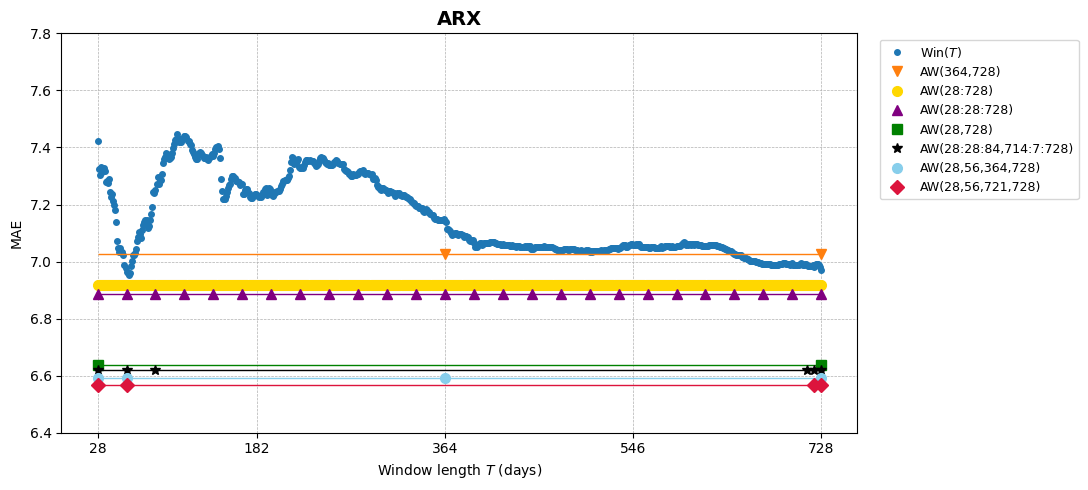

In [43]:
# Visualize MAE for single windows and averaged-window strategies
plot_order = [
    ('AW(364,728)', 'v', 'tab:orange'),
    ('AW(28:728)', 'o', 'gold'),
    ('AW(28:28:728)', '^', 'purple'),
    ('AW(28,728)', 's', 'green'),
    ('AW(28:28:84,714:7:728)', '*', 'black'),
    ('AW(28,56,364,728)', 'o', 'skyblue'),
    ('AW(28,56,721,728)', 'D', 'crimson'),
]

fig, ax = plt.subplots(figsize=(11, 5))

# --- Win(T) for ARX ---
ax.plot(
    Win_T['T'], Win_T['MAE'],
    'o', color='tab:blue', markersize=4,
    label=r"$\mathrm{Win}(T)$"
)

# --- AW sets ---
for (name, marker, color) in plot_order:
    row = AW[AW['Name'] == name]
    if row.empty:
        continue

    mae = row['MAE'].values[0]
    ax.hlines(mae, xmin=28, xmax=728, colors=color, linestyles='-', linewidth=1)

    x_points = np.array(set_defs[name])
    y_points = np.full_like(x_points, mae, dtype=float)

    ax.plot(x_points, y_points, marker=marker, color=color,
            linestyle='None', markersize=7, label=name)

ax.set_xlabel('Window length $T$ (days)')
ax.set_ylabel('MAE')
ax.set_ylim([6.4, 7.8])
ax.set_title('ARX', fontweight='bold', fontsize=14)
ax.set_xticks([28, 182, 364, 546, 728])
ax.grid(True, linestyle='--', linewidth=0.5)

# --- Legend shifted to the right ---
ax.legend(fontsize=9, loc='upper left',
          bbox_to_anchor=(1.02, 1), frameon=True)

plt.tight_layout()
plt.show()

In [44]:
# Compare each averaging strategy to the Win(728) baseline in percent terms
AW_sorted = {}

baseline_T = 728
baseline_mae = Win_T.loc[Win_T['T'] == baseline_T, 'MAE'].values[0]

df = AW.copy()
df['Delta_log_vs_Win728'] = np.log(baseline_mae / df['MAE'])
df['Pct_change_vs_Win728'] = (baseline_mae / df['MAE'] - 1) * 100

df = df.sort_values('Pct_change_vs_Win728', ascending=False).reset_index(drop=True)
AW_sorted = df[['Name', 'MAE', 'Pct_change_vs_Win728']]